In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh, eig
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import sys
import random as rn
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [2]:
'''
Insert parameters for the nucleus
A: mass number
Z: proton number
g_A: axial-vector coupling

'''

A = 74
Z = 28
g_A = 1.0 # axial-vector coupling 

In [3]:
# distribuution of the feeding strength, first the GT
import scipy.integrate as integrate
from scipy.special import gamma
import scipy.integrate as integrate

emass = 0.511 # MeV
alpha_c = 1/137
hbarc = 197.33 # MeV fm
compton = hbarc/emass # fm
kappa = 6147 #s
del_np = 1.293 # MeV
del_nH = 0.782 # MeV





# define the Fermi function as a function of electron energy
def Fermi(Z,A,W):
    
    R = 1.2*A**1/3
    R = R / compton
    
    gamma_1 = np.sqrt(1 - (alpha_c*Z)**2)
    p = np.sqrt(W**2 - 1)
    y = alpha_c*Z*W/p
    
    gamma_part = np.abs(gamma(gamma_1 + 1j*y))**2/gamma(2*gamma_1+1)**2
    part_1 = 4*(2*p*R)**(-2*(1-gamma_1))
    part_2 = np.exp(np.pi*y)
    L_0 = 0.5*(1+ gamma_1)
    
    return part_1*part_2*gamma_part*L_0



# define the phase factor integral
# p W ( W0 - W)**2 F(Z,W)

def phase_factor_integrand(kind,Z,A,W_0,W):
    '''
    Based on the kind argument I can have different types
    of phase-space factors

    kind = 0: pW(W_0-W)^2F(Z,W)


    '''
    
    if (W**2 - 1 < 0): return 0
    p = np.sqrt(W**2 - 1)

    if (kind == 0):
        return p*W*(W_0-W)**2*Fermi(Z+1,A,W)
    elif (kind == 1): # ka
        return p*W**2*(W_0-W)**2*Fermi(Z+1,A,W)
    elif (kind == 2): # kb
        return p*(W_0-W)**2*Fermi(Z+1,A,W)
    elif (kind == 3): # kc
        return p*W**3*(W_0-W)**2*Fermi(Z+1,A,W)
    else:
        print('Wrong kind in phase_factor_integrand!')
        exit(-1)


def phase_factor(kind,Z,A,W_0):

    '''
    Performs integration of the phase_factor_integrand function
    '''
    
    integrand = lambda W: phase_factor_integrand(kind,Z,A,W_0,W)
    
    res, err = integrate.quad(integrand, 1, W_0)
    

    return res

def theta2(K_val):
    if (K_val == 0):
        return 1
    else:
        return 2

In [4]:
'''
All this does is shuffle the dataset into training, test and cross-validation sets

'''

rn.seed(42)

# split the data into test set and so on
alpha_values = np.linspace(0,1.5,16)
formatted_alpha_values = [f"{num:.3f}" for num in alpha_values]
beta_values = np.linspace(0,1.,11)
formatted_beta_values = [f"{num:.3f}" for num in beta_values]


# Example lists
alpha = formatted_alpha_values
beta = formatted_beta_values

# Combine the lists into pairs
combined = combined = [(x, y) for x in alpha for y in beta]
# Shuffle the combined list
rn.shuffle(combined)

# Define split ratios (e.g., 60% train, 20% cv, 20% test)
train_ratio = 0.6
cv_ratio = 0.2
test_ratio = 0.2

# Calculate the number of elements for each set
n = len(combined)
n_train = int(n * train_ratio)
n_cv = int(n * cv_ratio)
n_test = n - n_train - n_cv  # Ensure all elements are used

# Split the combined list
train_set = combined[:n_train]
cv_set = combined[n_train:n_train + n_cv]
test_set = combined[n_train + n_cv:]



print(len(test_set), len(cv_set), len(train_set))


36 35 105


(20, 20) (20, 20) (20, 20)
Number of parameters:  460
Iteration 0, Cost: 1507964.379707069
CV cost:  357042.2444356159
Iteration 100, Cost: 67779.07043109536
CV cost:  22078.108395866206
Iteration 200, Cost: 11141.778435611537
CV cost:  3563.0695249130413
Iteration 300, Cost: 6922.165739442901
CV cost:  2694.852858195149
Iteration 400, Cost: 5263.470557699748
CV cost:  2068.1597042376984
Iteration 500, Cost: 4278.4274867026
CV cost:  1676.0622593477724
Iteration 600, Cost: 3624.7125849628596
CV cost:  1421.0846173694645
Iteration 700, Cost: 3188.2719771979596
CV cost:  1261.6559028244587
Iteration 800, Cost: 2872.474431224455
CV cost:  1141.0736239111588
Iteration 900, Cost: 2787.613654393019
CV cost:  1026.3179859272389
Iteration 1000, Cost: 2385.6757200926922
CV cost:  946.8104973682114
Iteration 1100, Cost: 2205.7664475620495
CV cost:  880.6695962066734
Iteration 1200, Cost: 2175.8277376296087
CV cost:  858.3074318919344
Iteration 1300, Cost: 1921.4131045680722
CV cost:  771.5789303

Text(0, 0.5, 'Cost function')

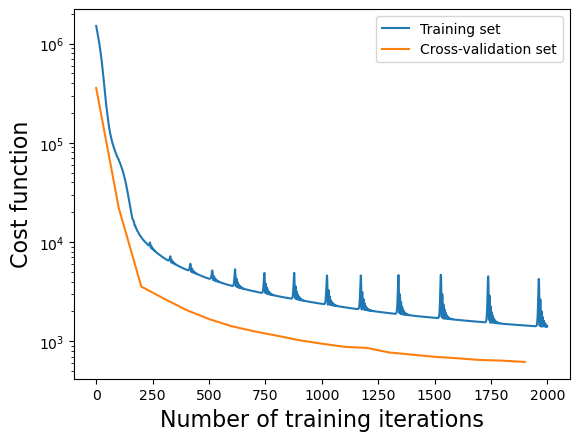

In [10]:
'''
This code generalizes to the 2D problem

M(alpha,beta) = D + alpha * S1 + beta * S2

'''
# alpha_values = np.linspace(0,1.5,16)
# formatted_alpha_values = [f"{num:.3f}" for num in alpha_values]
# beta_values = np.linspace(0,1.,11)
# formatted_beta_values = [f"{num:.3f}" for num in beta_values]

# Seed for reproducibility
np.random.seed(42)

@tf.function
def give_me_Lorentzian(energy, poles, strength, width):
    if isinstance(energy, np.ndarray):
        energy = tf.convert_to_tensor(energy, dtype=tf.float64)

    poles = tf.convert_to_tensor(poles, dtype=tf.float64)
    strength = tf.convert_to_tensor(strength, dtype=tf.float64)
    width = tf.constant(width, dtype=tf.float64)

    energy_expanded = tf.expand_dims(energy, axis=-1)

    numerator = strength * (width / 2 / np.pi)
    denominator = ((energy_expanded - poles) ** 2 + (width ** 2 / 4))
    
    lorentzian = numerator / denominator

    value = tf.reduce_sum(lorentzian, axis=-1)
    
    return value

# Parameters#####################
''' Change this parameter'''
n = 20 # size of PMM matrices
eta_learn = 0.5 # widths of Lorentzians to learn
#################################

# nec_mat for M_true(a) = D + a * S1 + b * S2
def nec_mat(n):
    D = np.diag(np.random.uniform(1, 10, n))
    A = np.random.uniform(1, 10, (n, n))
    B = np.random.uniform(1, 10, (n, n))
    S1 = np.abs(A + A.T) / 2
    S2 = np.abs(A + A.T) / 2
    return D, S1, S2

D, S1, S2 = nec_mat(n)
print(D.shape, S1.shape, S2.shape)


# initialize the external field vector
v0 = np.random.rand(n)

# generalized_eigen for M_true(a)
def generalized_eigen(D, S1, S2, alpha):
    M_true = D + float(alpha[0]) * S1 + float(alpha[1]) * S2
    eigenvalues, eigenvectors = eigh(M_true)
    return np.real(eigenvalues), np.real(eigenvectors)




def data_table(fmt_data):
    '''
    
    Here split the dataset from "new_data" folder
    into: training set, validation set and test set
    use any ratio you like (e.g. 0.8 0.1 0.1)
    
    For the optimizatio use only training set, and after you finish
    test it on validation set
    
    returns also number of QRPA poles n_QRPA
    
    '''
    eigenvalues = []
    Bs = [] 
    

    for frmt in fmt_data:
        
        alpha = frmt[0]
        beta = frmt[1]

        # first open the file with the data
        file = np.loadtxt('new_data/excm_Ni_74_'+beta+'_'+alpha+'.out')

        file = file[file[:,0]<del_nH]

        eigenvalues.append(file[:,0])  
        Bs.append(file[:,1])

     
    return eigenvalues, Bs

'''
    data table is now constructed for alpha & beta parameters
'''

eigenvalues, Bs = data_table(train_set)
eigenvalues_cv, Bs_cv = data_table(cv_set)


def modified_DS(params, D_shape, S1_shape, S2_shape):
    '''

     added v0 in the mix
     
     added S1_shape & S2_shape 
     
     params: tf.Variable
     D_shape: int, shape of diagonal matrix
     S1_shape : int
     S2_shape : int
     
     given params, construct D, S1 and S2 matrices , 
     as well as the external field v0
    
    '''
    # initialize v0, D, S1 and S2
    v0_mod = tf.convert_to_tensor(params[:n])
    D_mod = tf.linalg.diag(params[n:D_shape[0]+n])
    S1_mod = tf.zeros(S1_shape, dtype=tf.float64)
    S2_mod = tf.zeros(S2_shape, dtype=tf.float64)
    
    # construct S1 and S2 matrices
    upper_tri_indices1 = np.triu_indices(S1_shape[0])
    indices1 = tf.constant(list(zip(upper_tri_indices1[0], upper_tri_indices1[1])))
    S1_mod = tf.tensor_scatter_nd_update(S1_mod, indices1,\
            params[D_shape[0]+n:D_shape[0] + len(upper_tri_indices1[0])+n])
    
    S1_mod = S1_mod + tf.linalg.band_part(tf.transpose(S1_mod), -1, 0) - tf.linalg.diag(tf.linalg.diag_part(S1_mod))
    
    
    upper_tri_indices2 = np.triu_indices(S2_shape[0])
    indices2 = tf.constant(list(zip(upper_tri_indices2[0], upper_tri_indices2[1])))
    S2_mod = tf.tensor_scatter_nd_update(S2_mod, indices2 \
    , params[D_shape[0] + len(upper_tri_indices1[0])+n:D_shape[0] \
        + len(upper_tri_indices1[0])+n+len(upper_tri_indices2[0])])
    
    S2_mod = S2_mod + tf.linalg.band_part(tf.transpose(S2_mod), -1, 0) - tf.linalg.diag(tf.linalg.diag_part(S2_mod))
    
    
    return D_mod, S1_mod, S2_mod, v0_mod

# cost_function
def cost_function(params, D_shape, S1_shape, S2_shape, fmt_data, eigenvalues_true, Bs_true):
    
    '''
    params: tf.Variable
    D_shape, S1_shape, S2_shape : int
    alpha_values, beta_values: list
    data_table: pd.DataFrame
    
    calculates the cost function by subtracting two Lorentzians
    
    '''
    
    D_mod, S1_mod, S2_mod, v0_mod = modified_DS(params, D_shape, S1_shape, S2_shape)
    
    total_cost = 0
    
    count = 0
    for idx, alpha in enumerate(fmt_data):

        M_true = D_mod + float(alpha[0]) * S1_mod + float(alpha[1]) * S2_mod

        eigenvalues, eigenvectors = tf.linalg.eigh(M_true)
#         red_dim = int(len(eigenvalues)*0.8)
#         eigenvalues = eigenvalues[:red_dim]
#         eigenvectors = eigenvectors[:,:red_dim]


        true_eigenvalues = tf.constant(eigenvalues_true[count], dtype=tf.float64)
        B = [tf.square(tf.tensordot(eigenvectors[:, i], v0_mod, axes=1)) for i in range(eigenvectors.shape[1])]
        true_B = tf.constant(Bs_true[count], dtype=tf.float64)

        #Generate the x values
        x = tf.linspace(tf.reduce_min(true_eigenvalues) , tf.reduce_max(true_eigenvalues) , 1000)

        # Use tf.map_fn to apply the give_me_Lorentzian function over the x values
        Lor_true = give_me_Lorentzian(x, true_eigenvalues, true_B, eta_learn)
        Lor = give_me_Lorentzian(x, eigenvalues, B, eta_learn)

        total_cost += tf.reduce_sum((Lor - Lor_true) ** 2)

        count+=1
            
    return total_cost, Lor, Lor_true, x

# # PART3

# # Optimization setup

# Initialize the parameters (variables) to be optimized
nec_num_param = n + 2*int(n * (n + 1) / 2) + n # add v0 to the mix (last n)
print('Number of parameters: ', nec_num_param)
random_initial_guess = np.random.uniform(0, 1, nec_num_param)

params_shape = [D.shape, S1.shape, S2.shape]

params = tf.Variable(random_initial_guess, dtype=tf.float64)


optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)


# Optimization step function
@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        cost, Lor, Lor_true,x = cost_function(params, D.shape, S1.shape, S2.shape, train_set\
                                              , eigenvalues, Bs)
    gradients = tape.gradient(cost, [params])
    optimizer.apply_gradients(zip(gradients, [params]))
    return cost, Lor, Lor_true, x

def cv_step():
    '''
        Loss function for cross-validation
    '''
    cost, Lor, Lor_true,x = cost_function(params, D.shape, S1.shape, S2.shape, cv_set\
                                      , eigenvalues_cv, Bs_cv)
  
    return cost

# Run the optimization
''' Change num_iterations '''
num_iterations = 2000 # Total number of optimization iterations
num_check = 100 #Print output after this many steps
cost_loop = []
cost_loop_cv = []
for i in range(num_iterations):
    cost, Lor, Lor_true, x = optimization_step()
    current_learning_rate = optimizer._decayed_lr(tf.float32).numpy()
    cost_loop.append(cost.numpy())
    
    
    if i % num_check == 0:  # Print cost every 100 iterations
        cost_cv = cv_step()
        cost_loop_cv.append(cost_cv.numpy())
        print(f"Iteration {i}, Cost: {cost.numpy()}")
        print('CV cost: ', cost_cv.numpy())
        
    
#         plt.figure()
#         plt.plot(x.numpy(),Lor.numpy(), label='Optimized Lorentzian', color = 'red')
#         plt.plot(x.numpy(),Lor_true.numpy(), label='QRPA calculation', linestyle='dashed', color = 'blue')
#         plt.legend()
#         plt.xlabel('E [MeV]', size = 18)
#         plt.ylabel('$S$ [1/MeV]', size = 18)
#         plt.ylim(0)
#         plt.title('Iteration: '+ str(i))
#         plt.axvline(0.789, color = 'black')
#         plt.annotate(r'$\beta$-decay window', (0.25,0.6), xycoords='axes fraction', rotation=90)
#         plt.show()

plt.plot(range(num_iterations), cost_loop, label = 'Training set')
plt.plot(np.array(range(int(num_iterations/num_check)))*100, cost_loop_cv, label = 'Cross-validation set')
plt.yscale('log')
print('Final: ', cost.numpy())
plt.xlabel('Number of training iterations', size = 16)
plt.legend()
plt.ylabel('Cost function', size = 16)

Text(0, 0.5, '$S$ [1/MeV]')

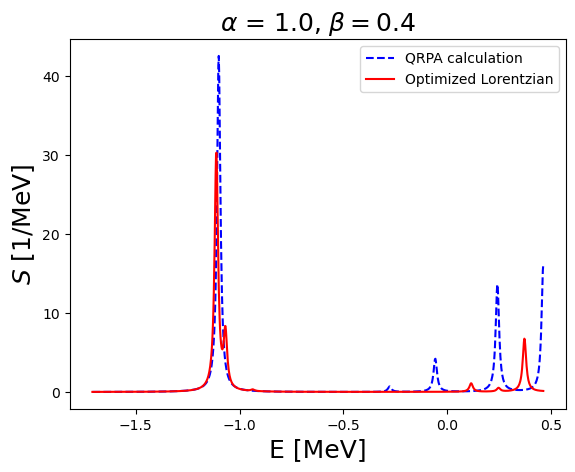

In [11]:
def give_me_Lorentzian(energy, poles, strength, width):
    
    value = 0
    W_0 = (del_np - energy)/emass
    for i in range(len(poles)):
        value += strength[i]/((energy-poles[i])**2 + width**2/4)*width/2/np.pi\
        #*evaluate_polynomial_np(coeffs,W_0)*g_A**2*np.log(2)/kappa
        
    return value
        



idx = 10
alpha = float(test_set[idx][0])
beta = float(test_set[idx][1])


eigenvalues_test, Bs_test = data_table(test_set)
orig_eigenvalues = eigenvalues_test[idx]
orig_dot_products = Bs_test[idx]

opt_D, opt_S1, opt_S2, opt_v0 = modified_DS(params.numpy(), params_shape[0], params_shape[1], params_shape[2])
opt_eigenvalues, opt_eigenvectors = generalized_eigen(opt_D.numpy(), opt_S1.numpy(), opt_S2.numpy(), test_set[idx])
opt_dot_products = [np.square(np.dot(opt_eigenvectors[:, i], opt_v0.numpy())) for i in range(opt_eigenvectors.shape[1])]



fig, ax = plt.subplots()



# plot the Lorentzian for the original data
x = np.linspace(np.min(orig_eigenvalues)-0.1, np.max(orig_eigenvalues),1000)
orig_Lor = []
opt_Lor = []
for en in x:
    orig_Lor.append(give_me_Lorentzian(en,orig_eigenvalues,orig_dot_products,0.02))
    opt_Lor.append(give_me_Lorentzian(en,opt_eigenvalues,opt_dot_products,0.02))

plt.plot(x, orig_Lor, 'b--',label='QRPA calculation')    
plt.plot(x, opt_Lor, 'r-',label='Optimized Lorentzian')
    

ax.set_xlabel('Eigenvalue')
ax.set_ylabel('Dot Product')
ax.set_title(r'$\alpha$ = '+str(round(alpha,1))+r', $\beta = $'+str(round(beta,1)), size = 18)
ax.legend()


plt.xlabel('E [MeV]', size = 18)
plt.ylabel('$S$ [1/MeV]', size = 18)

#print(params)

#plt.axvline(0.789, ls = '-', color = 'black')
#plt.ylim(0,10)
#plt.xlim(np.min(x),20)
#ax.set_xlim(-10,10)

#plt.savefig('strength_change_'+formatted_alpha_values[alpha_idx]+'.pdf', bbox_inches='tight')

From this point, we have new functions for calculating half-lives ...

In [12]:
orig_Lor = [[] for idx in range(len(test_set))]
opt_Lor = [[] for idx in range(len(test_set))]

for idx in range(len(test_set)):
    
    
    eigenvalues_test, Bs_test = data_table(test_set)
    orig_eigenvalues = eigenvalues_test[idx]
    orig_dot_products = Bs_test[idx]

    opt_D, opt_S1, opt_S2, opt_v0 = modified_DS(params.numpy(), params_shape[0], params_shape[1], params_shape[2])
    opt_eigenvalues, opt_eigenvectors = generalized_eigen(opt_D.numpy(), opt_S1.numpy(), opt_S2.numpy(), test_set[idx])
    opt_dot_products = [np.square(np.dot(opt_eigenvectors[:, i], opt_v0.numpy())) for i in range(opt_eigenvectors.shape[1])]


    # plot the Lorentzian for the original data
    x = np.linspace(np.min(orig_eigenvalues)-0.1, np.max(orig_eigenvalues),1000)

    for en in x:
        orig_Lor[idx].append(give_me_Lorentzian(en,orig_eigenvalues,orig_dot_products,0.02))
        opt_Lor[idx].append(give_me_Lorentzian(en,opt_eigenvalues,opt_dot_products,0.02))

In the cell below, the half-lives are calculated, using the expression
\begin{equation}
  1/T_{1/2} = \frac{{ln}2}{\kappa} \int dW f(W) S(W, \eta)
\end{equation}
It loops over all the datapoints of the test set, and stores results in numpy arrays.


How do we know wheter PMM did a good job ?


We will use the following accuracy:
\begin{equation}
\bar{r} = \frac{1}{N_{test}} \sum_{i = 1}^{N_{test}} \log \frac{T_{1/2, i}^{PMM}}{T_{1/2, i}^{\text{test set}}}
\end{equation}
and the spread (RMSE)
\begin{equation}
\sigma = \sqrt{\frac{1}{N_{test}}\sum_{i = 1}^{N_{test}} (r_i - \bar{r})^2}
\end{equation}

Calculating point,  0
Calculating point,  1
Calculating point,  2
Calculating point,  3
Calculating point,  4
Calculating point,  5
Calculating point,  6
Calculating point,  7
Calculating point,  8
Calculating point,  9
Calculating point,  10
Calculating point,  11
Calculating point,  12
Calculating point,  13
Calculating point,  14
Calculating point,  15
Calculating point,  16
Calculating point,  17
Calculating point,  18
Calculating point,  19
Calculating point,  20
Calculating point,  21
Calculating point,  22
Calculating point,  23
Calculating point,  24
Calculating point,  25
Calculating point,  26
Calculating point,  27
Calculating point,  28
Calculating point,  29
Calculating point,  30
Calculating point,  31
Calculating point,  32
Calculating point,  33
Calculating point,  34
Calculating point,  35
Error:  0.038828240501207846
Spread: 0.07478022138347909


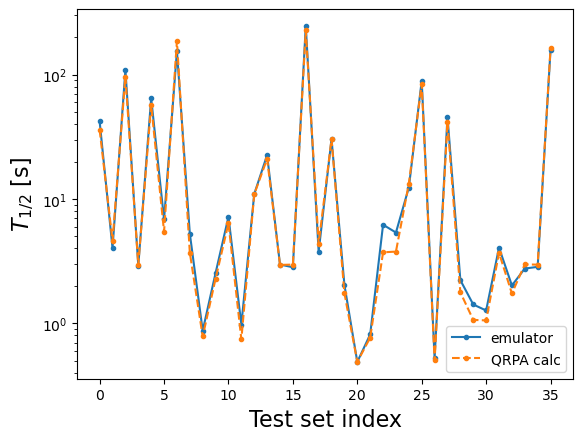

In [14]:



hl_guess = []
hl_orig = []

for idx in range(len(test_set)):
    
    print('Calculating point, ', idx)

    for k in range(2):


        omega = x
        if (k == 0):
            strength = opt_Lor[idx]
        else:
            strength = orig_Lor[idx]

        integ_all_GT = []


        for i in range(len(omega)):

            W_0 = (del_np - omega[i])/emass
            integ = phase_factor(0,Z+1,A,W_0)*strength[i]*g_A**2*np.log(2)/kappa
            integ_all_GT.append(integ)

        tot_rate = np.trapz(integ_all_GT, omega)
        #plt.step(omega[1:], integrate.cumulative_trapezoid(integ_all_GT, omega))

        #print(1/tot_rate)
        
        if (k == 0):
            hl_guess.append(1/tot_rate)
        else:
            hl_orig.append(1/tot_rate)


hl_orig = np.array(hl_orig)
hl_guess = np.array(hl_guess)

plt.plot([i for i in range(len(test_set))], hl_guess, marker = '.', label = 'emulator')  
plt.plot([i for i in range(len(test_set))], hl_orig, marker = '.', label = 'QRPA calc', ls = '--')  
plt.yscale('log')
plt.legend()
plt.ylabel('$T_{1/2}$ [s]', size = 16)
plt.xlabel('Test set index', size = 16)
#     plt.gca().tick_params(axis="y",direction="in", which = 'both', labelsize = 11)
#     plt.gca().tick_params(axis="x",direction="in", which = 'both', labelsize = 11)

#     print(len(omega))

# calculate RMSE error on half-lives
diffs = np.log10(hl_guess/hl_orig)
error = 1/len(hl_guess)*np.sum(diffs)
spread = np.sqrt(1/len(hl_guess)*np.sum(diffs**2))
print('Error: ', error)
print('Spread:', spread)



With $n = 10$ and $\eta_{train} = 0.5$ MeV, I get $\bar{r} = -0.010104076582607303$ and $\sigma = 0.09981836353625315$.

With $n = 20$ and $\eta_{train} = 0.5$ MeV, I get $\bar{r} = 0.038828240501207846$ and $\sigma = 0.07478022138347909$.